In [1]:
import sys
from pathlib import Path

# Get the absolute path to the base directory (one level up from notebook dir)
BASE_DIR = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

# Add to sys.path if not already present
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Now you can import directly
from zeromodel import ZeroModel


2025-08-11 20:44:57,058 - zeromodel.config - DEBUG - Added console logging handler
2025-08-11 20:44:57,059 - zeromodel.config - DEBUG - Added file logging handler: zeromodel.log
2025-08-11 20:44:57,060 - zeromodel.config - INFO - Logging configured at level: DEBUG
2025-08-11 20:44:57,060 - zeromodel.config - DEBUG - Configuration details:
2025-08-11 20:44:57,061 - zeromodel.config - DEBUG -   core: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-11 20:44:57,061 - zeromodel.config - DEBUG -   edge: {'enabled': False, 'default_tile_size': 3, 'output_precision': 'uint8', 'max_memory_usage': 25600}
2025-08-11 20:44:57,061 - zeromodel.config - DEBUG -   hierarchical: {'num_levels': 3, 'zoom_factor': 3, 'wavelet_type': 'haar'}
2025-08-11 20:44:57,062 - zeromodel.config - DEBUG -   logging: {'level': 'DEBUG', '

In [2]:
import matplotlib.pyplot as plt

def show_tile(u16_tile, title="Top-left tile"):
    # Normalize 16-bit channels to 0..1 for display
    img = (u16_tile / 65535.0)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


2025-08-11 20:44:57,245 - matplotlib - DEBUG - matplotlib data path: c:\Users\ernan\Project\zeromodel\venv\Lib\site-packages\matplotlib\mpl-data
2025-08-11 20:44:57,255 - matplotlib - DEBUG - CONFIGDIR=C:\Users\ernan\.matplotlib
2025-08-11 20:44:57,260 - matplotlib - DEBUG - interactive is False
2025-08-11 20:44:57,261 - matplotlib - DEBUG - platform is win32
2025-08-11 20:44:57,303 - matplotlib - DEBUG - CACHEDIR=C:\Users\ernan\.matplotlib
2025-08-11 20:44:57,306 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\ernan\.matplotlib\fontlist-v390.json


2025-08-11 20:44:57,468 - zeromodel.core - DEBUG - Initializing ZeroModel with metrics: ['uncertainty', 'size', 'quality', 'novelty'], config: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-11 20:44:57,482 - zeromodel.duckdb_adapter - DEBUG - DuckDB virtual_index table created with 4 metrics.
2025-08-11 20:44:57,484 - zeromodel.normalizer - DEBUG - Initializing DynamicNormalizer for 4 metrics
2025-08-11 20:44:57,484 - zeromodel.normalizer - INFO - Normalizer initialized with alpha=0.10 for metrics: ['uncertainty', 'size', 'quality', 'novelty']
2025-08-11 20:44:57,485 - zeromodel.vpm.encoder - DEBUG - VPMEncoder initialized with default output precision: float32
2025-08-11 20:44:57,486 - zeromodel.core - INFO - ZeroModel initialized with 4 metrics. Default output precision: float32.
2025-08-11 20:44:57,4

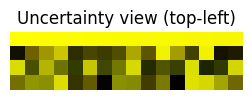

In [ ]:
import numpy as np
from zeromodel import ZeroModel

# 1) Build your score matrix: (docs x metrics)
docs, metrics = 500, ["uncertainty", "size", "quality", "novelty"]
X = np.random.rand(docs, len(metrics)).astype(np.float32)

zm = ZeroModel(metric_names=metrics)

# 2) Prepare once — writes a VPM-IMG (PNG) and stores it
zm.prepare(
    score_matrix=X,
    sql_query="SELECT * FROM virtual_index ORDER BY uncertainty DESC, size ASC",
    nonlinearity_hint=None,                     # or 'xor', 'product', etc.
    vpm_output_path="vpm_canonical.vpm.png",    # optional; defaults to cwd
)

# 3) Ask for a *view* (virtual order) or a *tile* (top-left window)
# 3a) Get document order for a single metric
order_uncert = zm.compile_view(metric_idx=0, top_k=16)        # 0 == 'uncertainty'

# 3b) Or combine metrics via weights (index -> weight)
weights = {0: 0.6, 2: 0.4}  # uncertainty 60%, quality 40 Because alright that's probably so that's not quite right%
order_combo = zm.compile_view(weights=weights, top_k=16)

# 3c) Extract the “critical tile” (top-left patch) for quick display
tile = zm.extract_critical_tile(metric_idx=0, size=16)         # shape: (H,W,3) uint16 Baby
show_tile(tile, title="Uncertainty view (top-left)")


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from zeromodel import ZeroModel

def show_tile_u16_r(tile_u16, title=""):
    # tile_u16 shape: (H, W, 3) uint16; visualize only R channel (value)
    r = tile_u16[..., 0].astype(np.float32)
    plt.figure(figsize=(3,3))
    plt.imshow(r, cmap="gray", vmin=0, vmax=65535)
    plt.title(title); plt.axis("off"); plt.show()

# 1) Build your score matrix: (docs x metrics)
docs, metrics = 500, ["uncertainty", "size", "quality", "novelty"]
X = np.random.rand(docs, len(metrics)).astype(np.float32)

zm = ZeroModel(metric_names=metrics)

# 2) Prepare once — writes a VPM-IMG (PNG) and stores it
zm.prepare(
    score_matrix=X,
    sql_query="SELECT * FROM virtual_index ORDER BY uncertainty DESC, size ASC",
    nonlinearity_hint=None,
    vpm_output_path="vpm_canonical.vpm.png",  # <-- correct kwarg name
)

# 3a) Get document order for a single metric
order_uncert = zm.compile_view(metric_idx=0, top_k=16)

# 3b) Or combine metrics via weights (index -> weight)
weights = {0: 0.6, 2: 0.4}
order_combo = zm.compile_view(weights=weights, top_k=16)

# 3c) Extract the “critical tile” (top-left patch) for quick display
tile = zm.extract_critical_tile(metric_idx=0, size=16)  # (H, W, 3) uint16
show_tile_u16_r(tile, title="Uncertainty (R channel, top-left)")
